In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn.functional as Fchat
import random
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F


c:\Users\luord\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
def get_cifar100_loaders(split_array = None, batch_size=500):
	transform = transforms.Compose([
		transforms.RandomCrop(32, padding=4),
		transforms.RandomHorizontalFlip(),
		transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
		transforms.ToTensor(),
		transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
	])
	
	trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
	testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
	
	if split_array is not None:
		total_size = len(trainset)
		split_sizes = [int(total_size * p) for p in split_array]

		# Ensure the sum does not exceed dataset size (due to rounding)
		split_sizes[-1] = total_size  # Ensure last split gets exactly the full dataset

		# Perform the splits
		sub_datasets = [random_split(trainset, [s, total_size - s])[0] for s in split_sizes]
		trainloader = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in sub_datasets]

	trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
	testloader = DataLoader(testset, batch_size=500, shuffle=True, num_workers=1) #testloader always has size 500
	
	return trainloader, testloader

In [5]:
class ResidualBlock(nn.Module):
	def __init__(self, inchannel, outchannel, stride=1):
		super(ResidualBlock, self).__init__()

		self.pre_activations1 = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
			nn.BatchNorm2d(outchannel))
		
		self.pre_activations2 = nn.Sequential(
			nn.ReLU(),
			nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
			nn.BatchNorm2d(outchannel)
		)

		self.shortcut = nn.Sequential()
		if stride != 1 or inchannel != outchannel:
			self.shortcut = nn.Sequential(
				nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
				nn.BatchNorm2d(outchannel)
			)
			
	def forward(self, x):
		pre_activations = self.pre_activations1(x)
		pre_activations2 = self.pre_activations2(pre_activations)
		out = pre_activations2 + self.shortcut(x)
		out = F.relu(out)
		return out, pre_activations, pre_activations2

class ResNet(nn.Module):
	def __init__(self, ResidualBlock, num_classes=100):
		super(ResNet, self).__init__()
		self.inchannel = 64
		self.conv1 = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
			nn.BatchNorm2d(64),
			nn.ReLU()
		)
		self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
		self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
		self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)        
		self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
		self.fc = nn.Linear(512, num_classes)
		
	def make_layer(self, block, channels, num_blocks, stride):
		strides = [stride] + [1] * (num_blocks - 1)
		layers = []
		for stride in strides:
			layers.append(block(self.inchannel, channels, stride))
			self.inchannel = channels
		return nn.ModuleList(layers)
	
	def forward(self, x):
		out = self.conv1(x)	
		pre_activations_list = []  # Store pre-activations
		
		pre_activations_list.append(out) # Pre-activation of the first layer

		# Iterate through each block to capture pre-activations
		for block in self.layer1:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	

		for block in self.layer2:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	
		
		for block in self.layer3:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	

		for block in self.layer4:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	
		

		out = F.avg_pool2d(out, 4)
		out = out.view(out.size(0), -1)
		out = self.fc(out)
		return out, pre_activations_list
	
def ResNet18():
	return ResNet(ResidualBlock)

In [ ]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)  # disable inplace to retain pre-activation

        self.pre_act = None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        self.pre_act = x.clone().detach()  # capture before ReLU
        x = self.relu(x)
        self.pre_act += x.clone().detach()  # capture after ReLU
        self.pre_act /= 2
        return x

In [ ]:
class VGGTracked(nn.Module):
    def __init__(self, cfg, num_classes=100, in_channels=3):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.feature_layers = self._make_layers(cfg, in_channels)
        
		# Infer the output shape to get the flattened feature size
        dummy_input = torch.zeros(1, 3, 32, 32)
        with torch.no_grad():
            dummy_out = self.feature_layers(dummy_input)
        flattened_dim = dummy_out.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_dim, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def _make_layers(self, cfg, in_channels):
        layers = []
        for x in cfg:
            if x == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                block = ConvBNReLU(in_channels, x)
                layers.append(block)
                self.blocks.append(block)
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.feature_layers(x)
        out = out.view(out.size(0), -1)
        return self.classifier(out)

    def get_activations(self):
        """Returns a list of (pre, post) activation tensors from each ConvBNReLU block."""
        return [(b.pre_act) for b in self.blocks]

In [8]:
def compute_accuracy(preds, labels):
	"""
	Computes the accuracy given predicted labels and true labels.
	
	Args:
		preds (torch.Tensor): Predicted labels (tensor of shape [batch_size])
		labels (torch.Tensor): True labels (tensor of shape [batch_size])
	
	Returns:
		float: Accuracy percentage
	"""
	correct = (preds == labels).sum().item()  # Count correct predictions
	total = labels.size(0)  # Total number of samples
	accuracy = correct / total * 100  # Compute percentage
	return accuracy

In [9]:
# Function to update the running average
def update_running_avg(new_tensor, running_sum, count):
	count += 1
	running_sum += new_tensor
	running_avg = running_sum / count
	return running_avg, running_sum, count

In [10]:
def test(model, device, test_loader, criterion, data_file, epoch, run, name):
	"""Evaluates the model on the test dataset and computes loss & accuracy."""
	model.eval()  # Set model to evaluation mode
	total_loss = 0.0
	outputs = torch.tensor([]).to(device)
	mean_layer_act = torch.tensor([]).to(device)
	
	column_names = [f'Layer{i+1}' for i in range(len(model.blocks))] # Define column names for csv file
	column_names.extend(['acc', 'avg_loss', 'epoch', 'run', 'model_name']) # Add extra info columns

	# Initialize running sum and count
	running_sum = torch.zeros(len(model.blocks)).to(device)  # len(model.blocks) = Number of layers
	count = 0

	with torch.no_grad():  # Disable gradient calculation
		for inputs, labels in test_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			for input, label in zip(inputs, labels):
				input, label = input.to(device), label.to(device)
				output = model(input.unsqueeze(0))
				outputs = torch.cat((outputs, output))
				pre_act = model.get_activations()
				for layer in pre_act:
					mean_layer_act = torch.cat((mean_layer_act,torch.mean(layer).unsqueeze(dim=0)))
				running_avg, running_sum, count = update_running_avg(mean_layer_act, running_sum, count)
				mean_layer_act = torch.tensor([]).to(device)

			loss = criterion(outputs, labels)  # Compute loss
			total_loss += loss.item()
			
			preds = torch.argmax(outputs, dim=1)  # Get predicted labels
			
			break # We only need one batch

	acc = compute_accuracy(preds, labels)
	avg_loss = total_loss / len(test_loader)  # Average loss

	numeric_data = torch.cat((running_avg, torch.tensor([acc, avg_loss, epoch, run]).to(device)))
	numeric_array = numeric_data.cpu().numpy()
	full_row = list(numeric_array) + [name]
	df = pd.DataFrame([full_row], columns=column_names)

	# Append to CSV, write header only if the file does not exist
	df.to_csv(data_file, mode='a', header=not os.path.exists(data_file), index=False)

	print(acc, avg_loss)
	return avg_loss, acc

In [11]:
class EarlyStopping:
	def __init__(self, patience=5, min_delta=0):
		"""
		Args:
			patience (int): How many epochs to wait before stopping if no improvement.
			min_delta (float): Minimum change to qualify as an improvement.
		"""
		self.patience = patience
		self.min_delta = min_delta
		self.best_loss = float('inf')  # Track best loss
		self.counter = 0  # Count epochs without improvement

	def __call__(self, avg_loss):
		"""Returns True if training should stop."""
		if avg_loss < self.best_loss - self.min_delta:
			self.best_loss = avg_loss  # Update best loss
			self.counter = 0  # Reset counter
		else:
			self.counter += 1  # Increase counter if no improvement
		
		return self.counter >= self.patience  # Stop if patience is exceeded

In [ ]:
def train(model, device, train_loader, test_loader, criterion, optimizer, run, name, epochs=5):
	model.train()
	# Define CSV file path
	data_file = 'activations_per_layer_vgg.csv'
	early_stopping = EarlyStopping(patience=10, min_delta=0.001)  # Adjust patience & delta

	dataset_size = len(train_loader.dataset)  # Get total dataset size
	progress_interval = int(dataset_size * 0.05)  # Compute 5% of dataset
	count = 0  # Initialize sample counter

	for epoch in range(epochs):

		for i, (inputs, labels) in enumerate(train_loader):
			count += len(inputs)  # Increment count by batch size
			inputs, labels = inputs.to(device), labels.to(device)
			
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			
		if count % progress_interval < len(inputs):  # Print every 5% of dataset
			avg_loss, acc = test(model, device, test_loader, criterion, data_file, epoch, run, name)
		
		
		if early_stopping(avg_loss):
			print("Early stopping triggered. Stopping training.")
			break  # Stop training

In [13]:
vgg_configs = {
    'vgg_tiny':      [32, 'M', 64, 'M'],                                    # Very small
    'vgg_small':     [64, 'M', 128, 'M'],                                   # Small
    'vgg_medium':    [64, 'M', 128, 'M', 256, 'M'],                         # Moderate depth
    'vgg_medium+':   [64, 64, 'M', 128, 'M', 256, 'M'],                     # Slightly deeper
    'vgg_large':     [64, 64, 'M', 128, 128, 'M', 256, 'M'],                # Deeper & more filters
    'vgg_large+':    [64, 64, 'M', 128, 128, 'M', 256, 256, 'M'],           # More capacity
    'vgg_xlarge':    [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M'],      # VGG-19 like
    'vgg_xlarge+':   [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M'], # Very deep
    'vgg_huge':      [64, 64, 'M', 128, 128, 'M', 256, 256, 512, 'M'],      # Added 512 block
    'vgg_huge+':     [64, 64, 'M', 128, 128, 'M', 256, 256, 512, 512, 'M']  # Largest
}

In [14]:
'''Training loop for models of different sizes'''

device = 'cuda'
num_runs = 2

train_loader, test_loader = get_cifar100_loaders(batch_size = 128)
criterion = nn.CrossEntropyLoss()

for name, config in vgg_configs.items():
	for run in range(num_runs):
		model = VGGTracked(config)
		model.to(device)
		optimizer = optim.Adam(model.parameters(), lr=0.001)

		train(model, device, test_loader, test_loader, criterion, optimizer, run, name, epochs=1) #Train for x epochs or until early stopping



2.8000000000000003 0.22640728950500488
2.6 0.22869336605072021
2.8000000000000003 0.22881975173950195
2.6 0.22765841484069824
2.4 0.22664618492126465
2.6 0.22753632068634033
2.6 0.22802908420562745
1.4000000000000001 0.2279451608657837
2.0 0.22714731693267823
1.6 0.22617158889770508
1.4000000000000001 0.2278261661529541
1.4000000000000001 0.22718288898468017
1.0 0.22878711223602294
1.6 0.22734830379486085
1.4000000000000001 0.230963134765625
2.4 0.22910783290863038
1.7999999999999998 0.22547078132629395
0.8 0.23163375854492188
1.6 0.22776784896850585
1.0 0.2305964469909668


In [ ]:
device = 'cuda'
num_runs = 5

train_loaders, test_loader = get_cifar100_loaders([0.2, 0.4, 0.6, 0.8, 1.0], 128)
criterion = nn.CrossEntropyLoss()

data_counter = 0
for train_loader in train_loaders:
	if data_counter >= 3:
		for run in range(num_runs):
			if run == 0 and data_counter == 3:
				run += 1
			model = VGGTracked(vgg_configs['vgg_medium'])
			model.to(device)
			optimizer = optim.Adam(model.parameters(), lr=0.001)

			train(model, device, train_loader, test_loader, criterion, optimizer, run, data_counter, epochs=100) #Train for x epochs or until early stopping

	data_counter += 1

TypeError: get_cifar100_loaders() takes from 0 to 2 positional arguments but 3 were given

In [48]:
# Replace 'your_file.csv' with the path to your CSV file
columns_to_exclude = ['acc', 'avg_loss', 'epoch', 'run']  # Replace with actual column names
df = pd.read_csv('activations_per_layer.csv')


# Drop the specified columns and compute the row-wise mean for the remaining columns
df['average'] = df.drop(columns=columns_to_exclude).mean(axis=1)


# df_avg['average'] = df_avg.mean(axis=1)

print(df)

ParserError: Error tokenizing data. C error: Expected 22 fields in line 447, saw 43


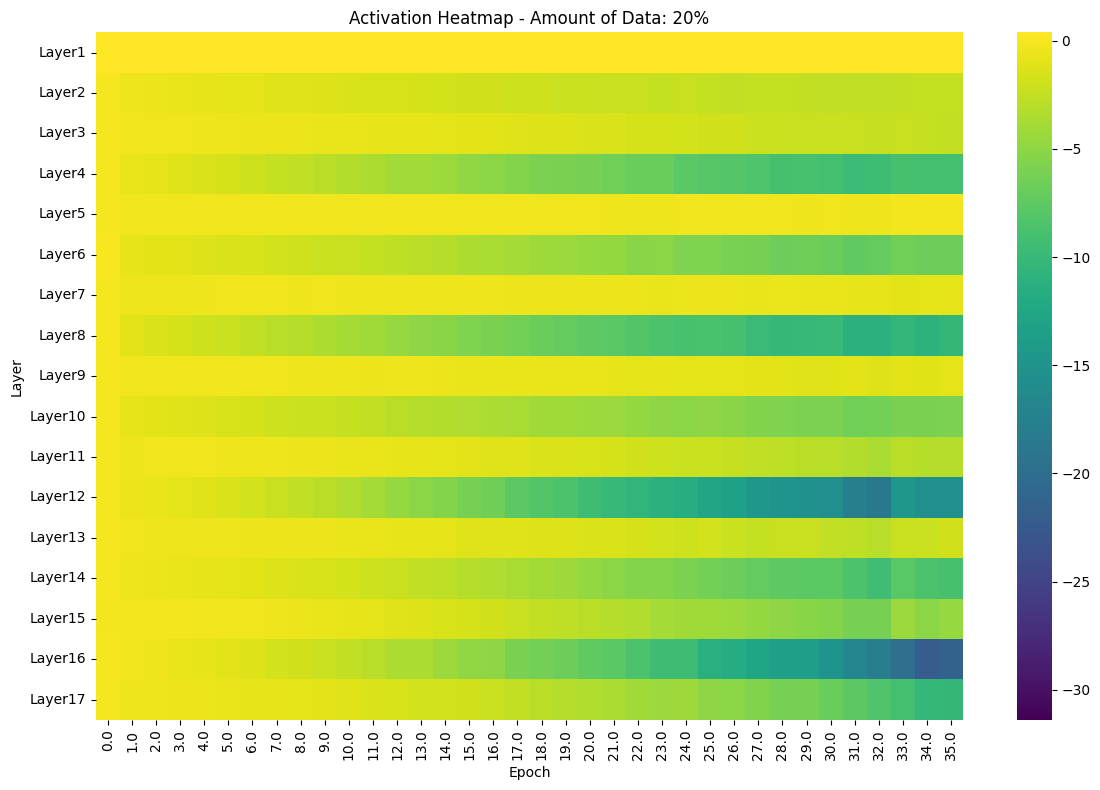

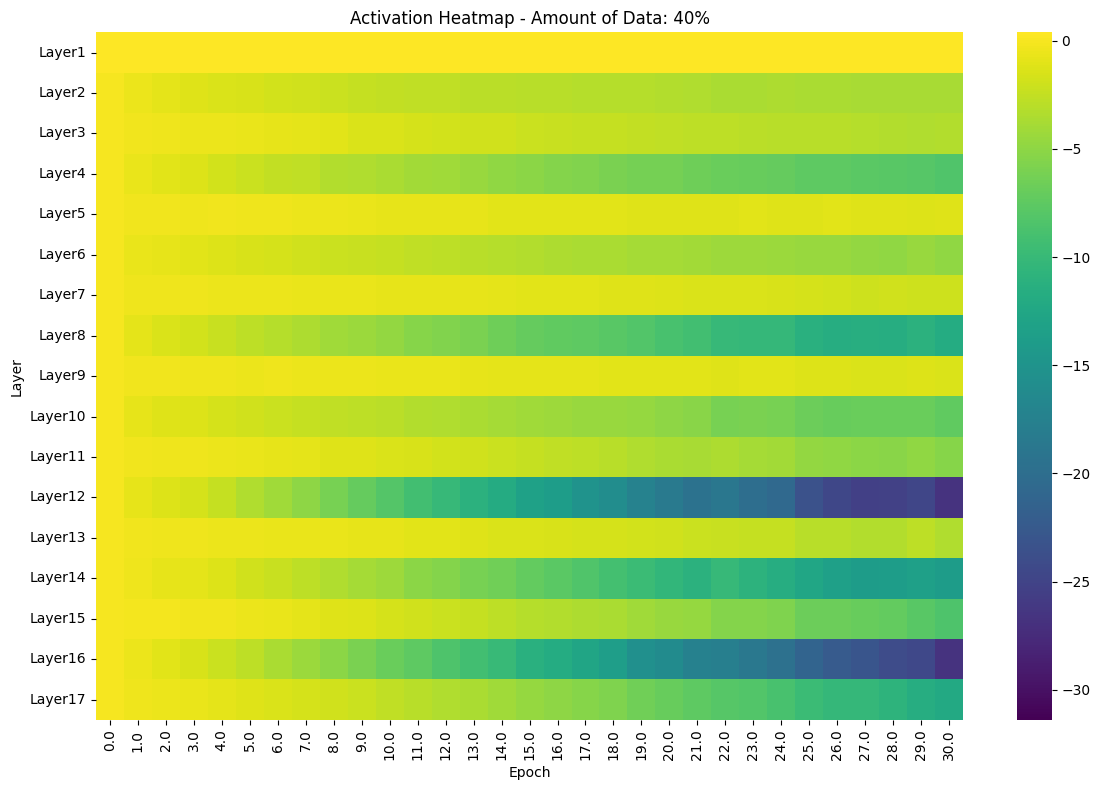

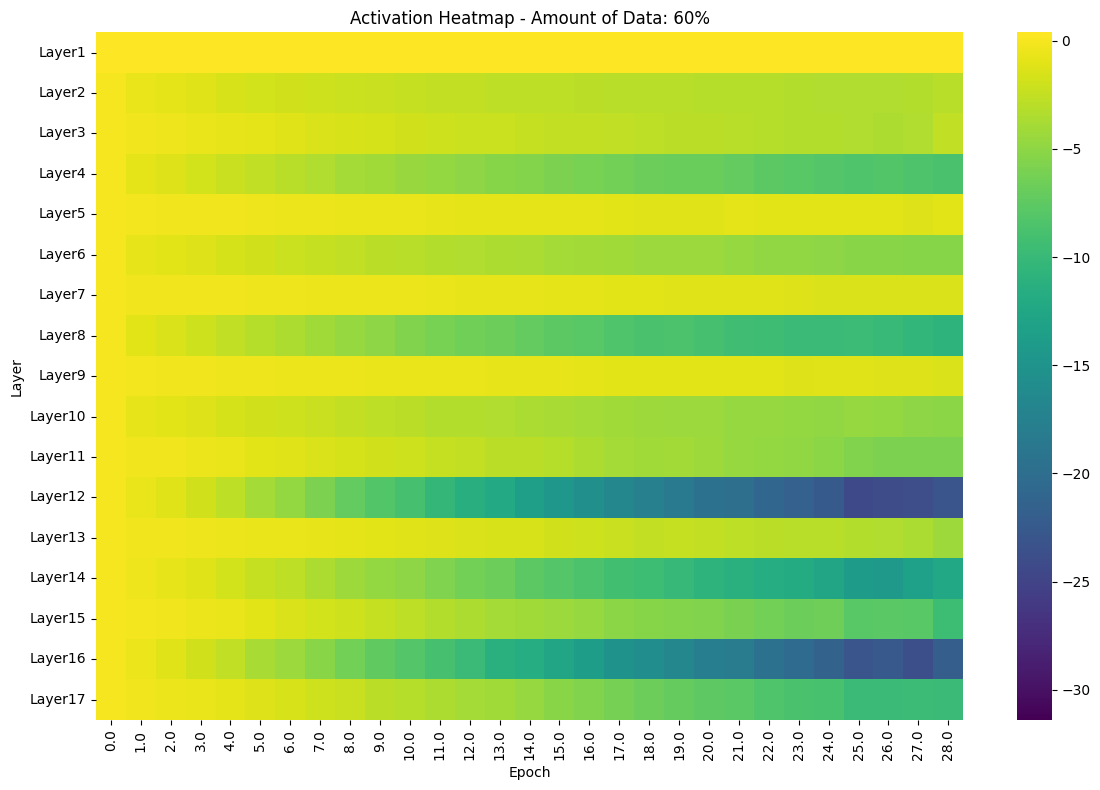

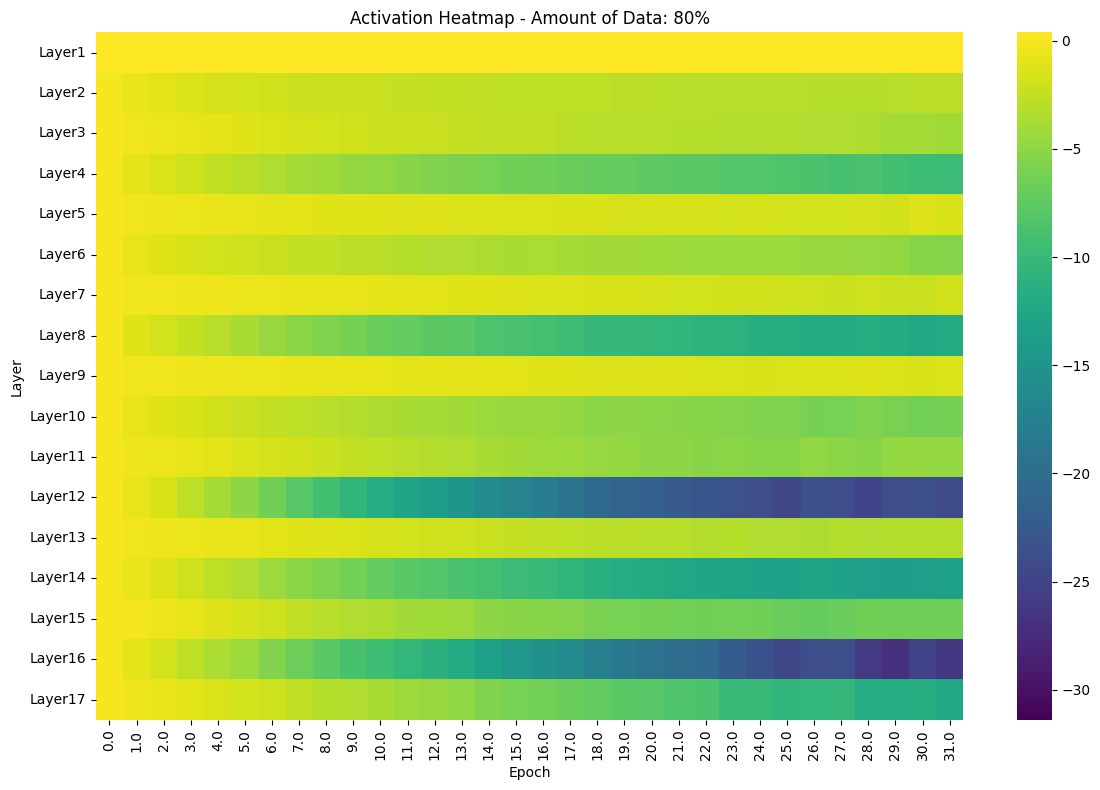

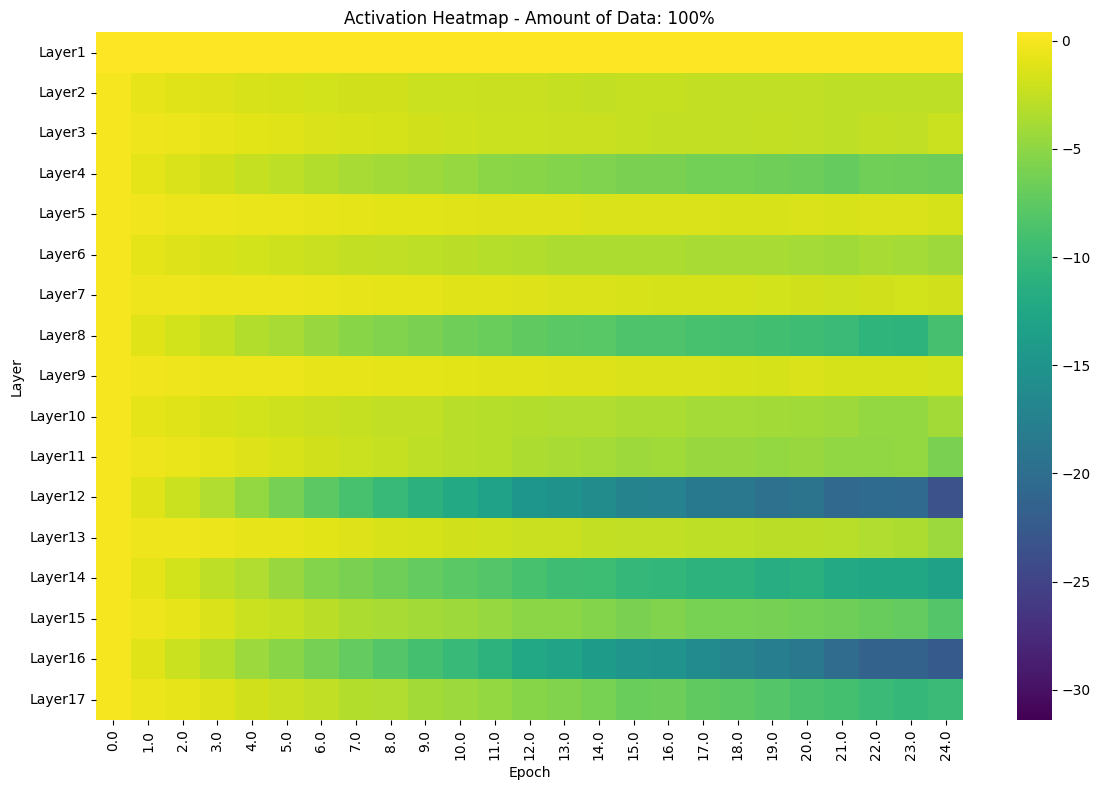

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('activations_per_layer.csv')

# Drop unused columns
columns_to_exclude = ['acc', 'avg_loss']
layer_columns = [col for col in df.columns if col.startswith('Layer')]
df_filtered = df.drop(columns=columns_to_exclude)

# Melt to long format
df_melted = df_filtered.melt(
    id_vars=['epoch', 'run', 'amount_of_data'], 
    value_vars=layer_columns, 
    var_name='layer', 
    value_name='activation'
)

# Sort the unique dataset sizes
unique_amounts = sorted(df_melted['amount_of_data'].unique())

# Compute global min and max activation values across the whole dataset for the layer activations
global_min = df_melted['activation'].min()
global_max = df_melted['activation'].max()

amount_map = {0: 20, 1: 40, 2: 60, 3: 80, 4: 100}

for amount in unique_amounts:
    df_subset = df_melted[df_melted['amount_of_data'] == amount].copy()
    
    df_subset['layer_num'] = df_subset['layer'].str.extract(r'(\d+)').astype(int)

    df_grouped = (
        df_subset
        .groupby(['layer', 'layer_num', 'epoch'])['activation']
        .mean()
        .reset_index()
        .sort_values('layer_num')
    )

    df_grouped['layer'] = pd.Categorical(
        df_grouped['layer'], 
        categories=df_grouped.sort_values('layer_num')['layer'].unique(),
        ordered=True
    )

    heatmap_data = df_grouped.pivot(index='layer', columns='epoch', values='activation')

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False, vmin=global_min, vmax=global_max)
    plt.title(f'Activation Heatmap - Amount of Data: {amount_map[amount]}%')
    plt.xlabel('Epoch')
    plt.ylabel('Layer')
    plt.tight_layout()
    plt.show()



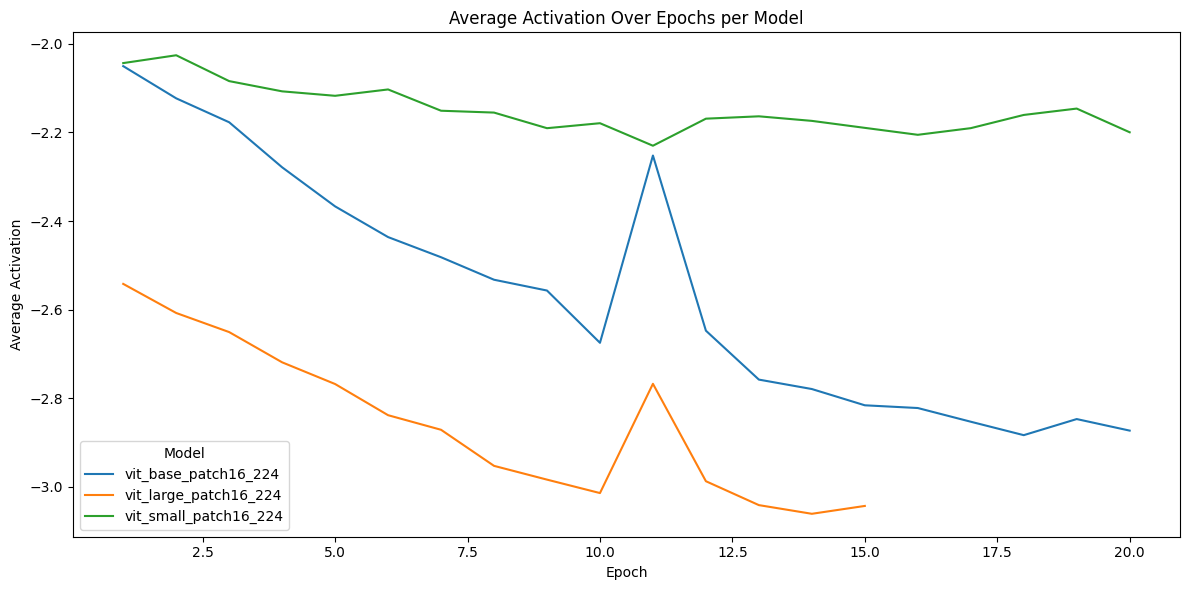

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('activations_csv/all_epochs.csv')


df_avg = df.groupby(['model', 'epoch'])['activation'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg, x='epoch', y='activation', hue='model')
plt.title('Average Activation Over Epochs per Model')
plt.xlabel('Epoch')
plt.ylabel('Average Activation')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

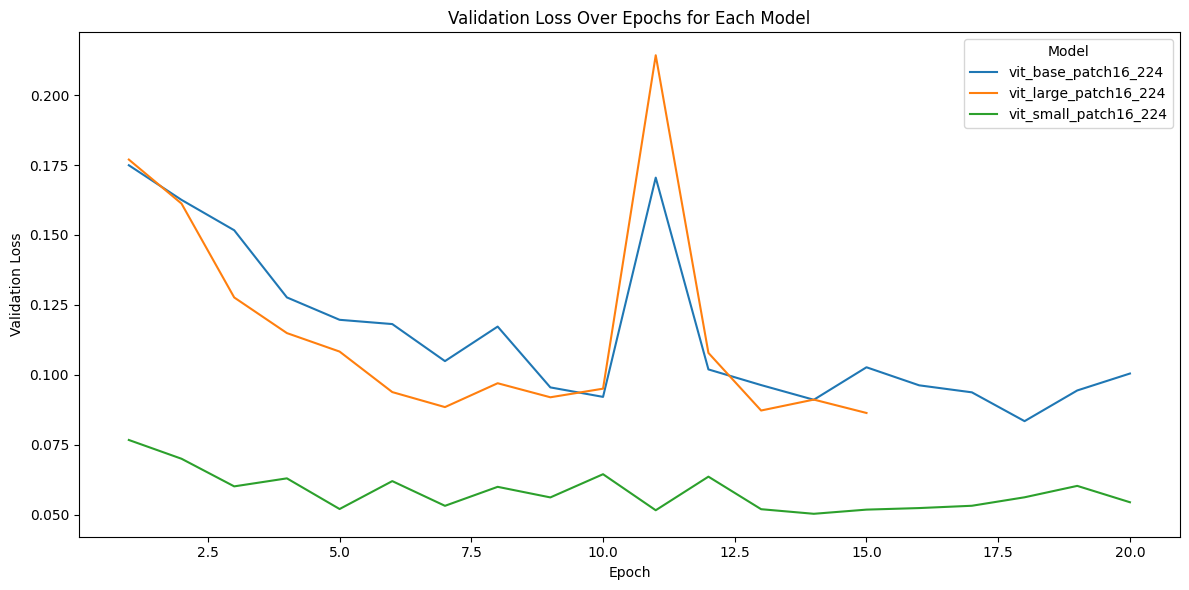

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_avg_loss = df.groupby(['model', 'epoch'])['val_loss'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_loss, x='epoch', y='val_loss', hue='model')
plt.title('Validation Loss Over Epochs for Each Model')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

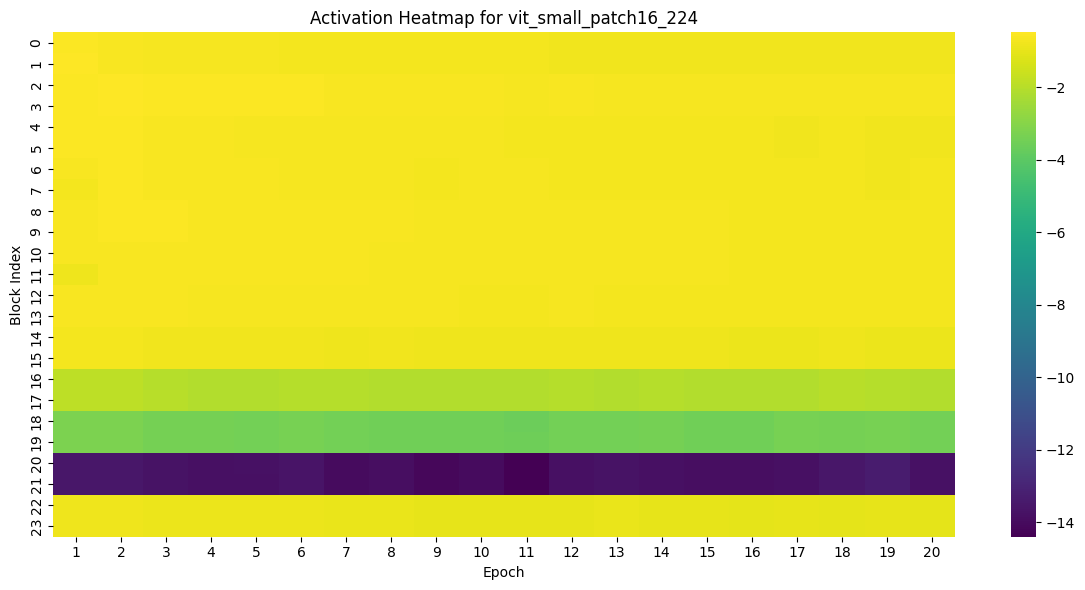

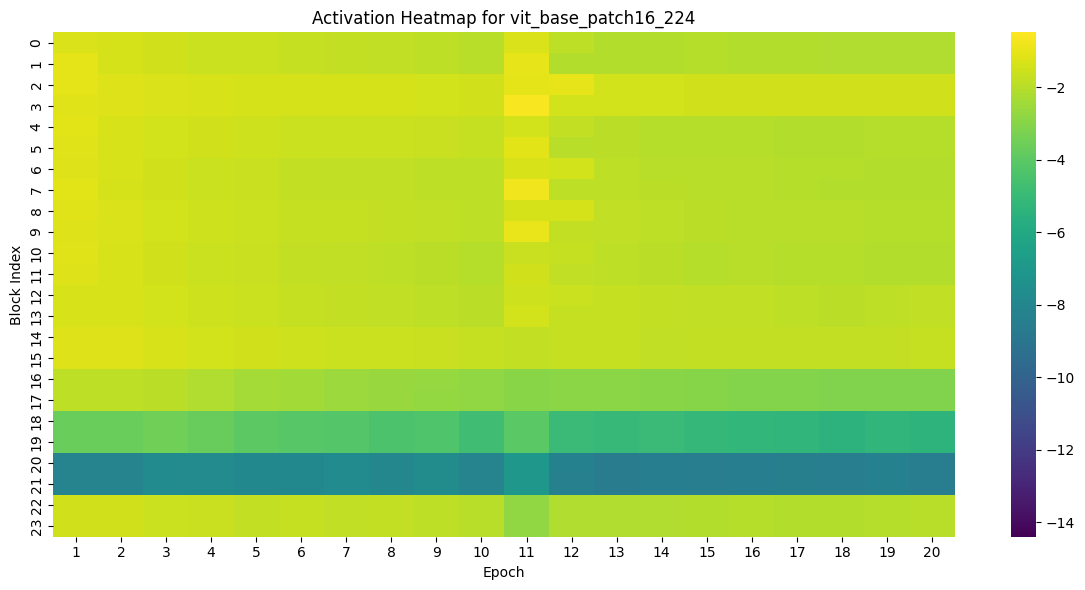

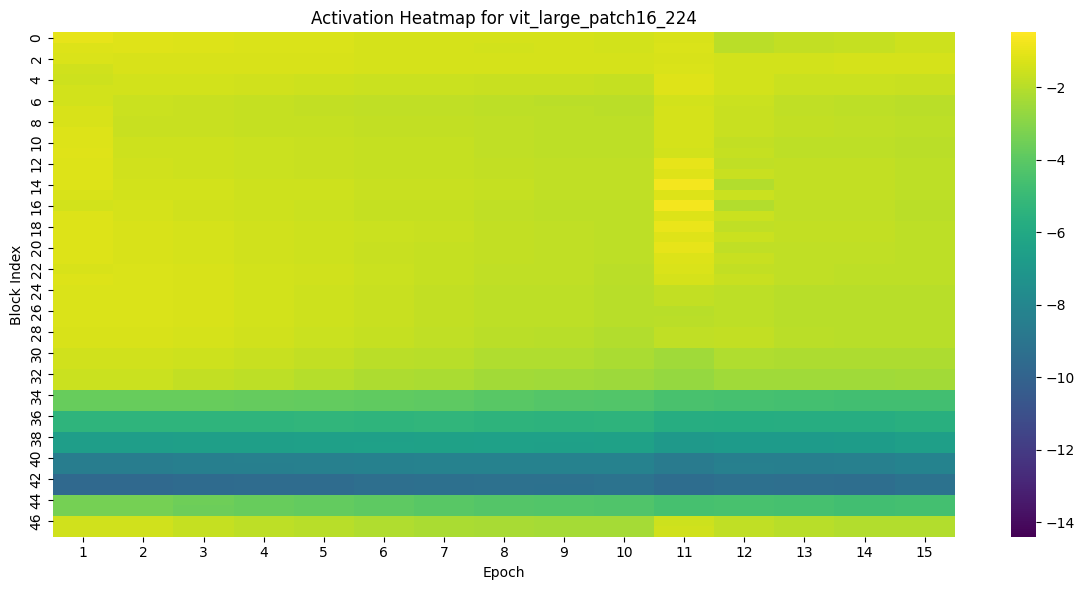

In [33]:
# Compute global activation range
global_min = df['activation'].min()
global_max = df['activation'].max()

models = df['model'].unique()

for model_name in models:
    df_model = df[df['model'] == model_name]
    df_pivot = df_model.groupby(['block_idx', 'epoch'])['activation'].mean().reset_index()
    heatmap_data = df_pivot.pivot(index='block_idx', columns='epoch', values='activation')

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_data,
        cmap='viridis',
        annot=False,
        vmin=global_min,
        vmax=global_max
    )
    plt.title(f'Activation Heatmap for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Block Index')
    plt.tight_layout()
    plt.show()

Fitted scaling law: val_loss = 0.029 * model_size^0.260


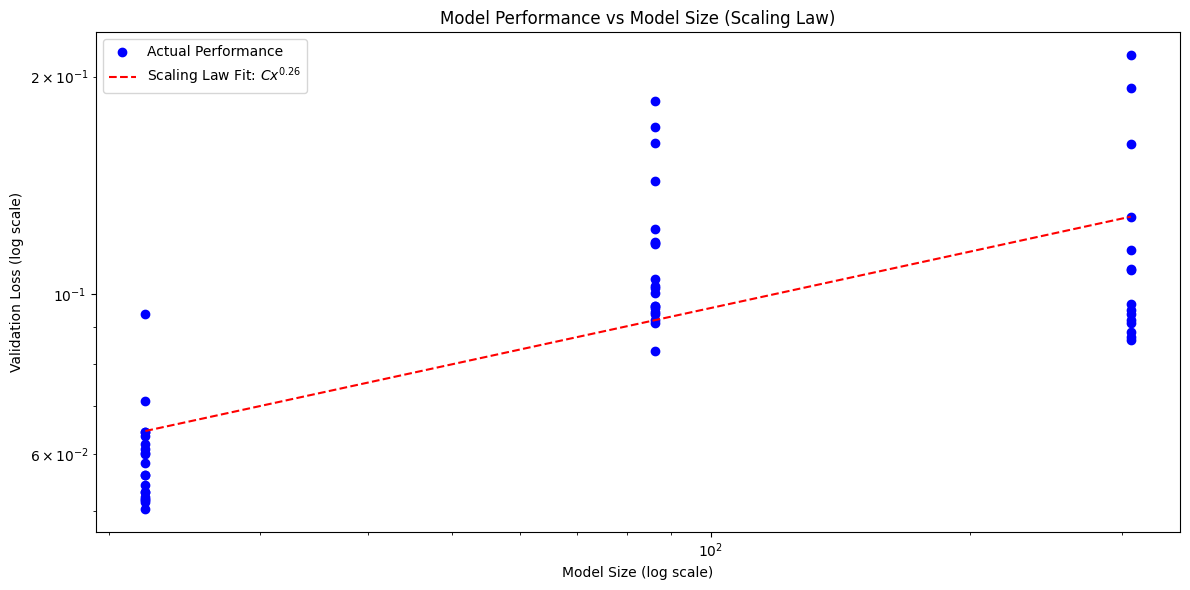

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


df_avg = df.groupby(['model', 'epoch'])['val_loss'].mean().reset_index()


model_size_dict = {
    'vit_small_patch16_224': 22.05, 
    'vit_base_patch16_224': 86.16,
    'vit_large_patch16_224': 307.48,
}

df_avg['model_size'] = df_avg['model'].map(model_size_dict)

df_avg = df_avg.dropna(subset=['model_size', 'val_loss'])


log_model_size = np.log(df_avg['model_size'])
log_val_loss = np.log(df_avg['val_loss'])

regressor = LinearRegression()
regressor.fit(log_model_size.values.reshape(-1, 1), log_val_loss)


log_C = regressor.intercept_
alpha = regressor.coef_[0]


C = np.exp(log_C)


print(f"Fitted scaling law: val_loss = {C:.3f} * model_size^{alpha:.3f}")


model_sizes_fit = np.linspace(min(df_avg['model_size']), max(df_avg['model_size']), 100)
val_loss_fit = C * model_sizes_fit ** alpha


plt.figure(figsize=(12, 6))
plt.scatter(df_avg['model_size'], df_avg['val_loss'], label='Actual Performance', color='blue')
plt.plot(model_sizes_fit, val_loss_fit, label=f'Scaling Law Fit: $C x^{{{alpha:.2f}}}$', color='red', linestyle='--')


plt.xscale('log')
plt.yscale('log')

plt.title('Model Performance vs Model Size (Scaling Law)')
plt.xlabel('Model Size (log scale)')
plt.ylabel('Validation Loss (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 3) set up a hook to capture pre‑GELU activations
pre_acts = []  # will be a list of tensors, one per block

def grab_pre_activation(module, inp, outp):
	# inp[0] is the Tensor coming out of the linear layer, before GELU
	pre_acts.append(inp[0].detach())

# register hook on every MLP’s first Linear → GELU
for blk in model.blocks:
	# print(blk)
	blk.mlp.fc1.register_forward_hook(grab_pre_activation)

# 4) run one batch (or more)
with torch.no_grad():
	for images, _ in train_loader:
		_ = model(images)
		break
		
# 5) compute stats
for i, pa in enumerate(pre_acts):
	# pa shape: [batch, num_patches+1, embed_dim]
	mean = pa.mean().item()
	frac_pos = (pa > 0).float().mean().item()
	print(f"Block {i:2d}:  mean={mean:.4f},  frac(>0)={frac_pos:.3%}")

['vit_small_patch16_18x2_224', 'vit_small_patch16_36x1_224', 'vit_small_patch16_224', 'vit_small_patch16_384']
Block  0:  mean=-0.0035,  frac(>0)=49.492%
Block  1:  mean=-0.0087,  frac(>0)=49.654%
Block  2:  mean=-0.0042,  frac(>0)=49.478%
Block  3:  mean=-0.0065,  frac(>0)=49.649%
Block  4:  mean=-0.0081,  frac(>0)=49.927%
Block  5:  mean=-0.0056,  frac(>0)=49.859%
Block  6:  mean=-0.0086,  frac(>0)=49.664%
Block  7:  mean=-0.0190,  frac(>0)=49.548%
Block  8:  mean=-0.1109,  frac(>0)=48.202%
Block  9:  mean=-0.1235,  frac(>0)=48.781%
Block 10:  mean=-0.1462,  frac(>0)=49.305%
Block 11:  mean=-0.0239,  frac(>0)=48.949%


In [ ]:
import torch
import timm
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from collections import defaultdict
import gc

# Training loop
def train_model(model, train_loader, val_loader, epochs=10):
	
	# Loss & optimizer
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

	block_acts = defaultdict(dict)
	avg_acts = []  # Final average activations (fc1 + fc2) per block

	model_name = model.default_cfg['architecture']
	hooks = []

	def make_hook(block_idx, layer_name):
		def hook(module, inp, outp):
			if not module.training:
				act = outp.detach()[1:]  # Remove CLS token
				mean_val = act.mean().item()

				block_acts[block_idx][layer_name] = mean_val

				if 'fc1' in block_acts[block_idx] and 'fc2' in block_acts[block_idx]:
					avg_val = (block_acts[block_idx]['fc1'] + block_acts[block_idx]['fc2']) / 2
					avg_acts.append(avg_val)

		return hook

	for idx, blk in enumerate(model.blocks):
		hook_fc1 = blk.mlp.fc1.register_forward_hook(make_hook(idx, 'fc1'))
		hook_fc2 = blk.mlp.fc2.register_forward_hook(make_hook(idx, 'fc2'))
		hooks.append(hook_fc1)
		hooks.append(hook_fc2)
		
	for epoch in range(epochs):
		model.train()
		running_loss = 0.0
		correct = 0
		total = 0

		loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")

		for images, labels in train_loader:
			images, labels = images.to(device), labels.to(device)

			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()

			running_loss += loss.item() * images.size(0)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

		train_loss = running_loss / len(train_loader.dataset)
		train_acc = 100. * correct / total

		# Validation
		model.eval()
		val_loss = 0.0
		val_correct = 0
		val_total = 0
		avg_acts = []

		with torch.no_grad():
			for images, labels in val_loader:
				images, labels = images.to(device), labels.to(device)
				outputs = model(images)
				loss = criterion(outputs, labels)
				val_loss += loss.item() * images.size(0)
				_, predicted = outputs.max(1)
				val_total += labels.size(0)
				val_correct += predicted.eq(labels).sum().item()
				break # Only do one batch for validation to grab the preactivations

		val_loss /= len(val_loader.dataset)
		val_acc = 100. * val_correct / val_total

		print(f"\nEpoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

		# Build DataFrame
		rows = []
		for block_idx, avg_activation in enumerate(avg_acts):
			row = {
				"model": model_name,
				"epoch": epoch + 1,
				"block_idx": block_idx,
				"val_loss": val_loss,
				"val_acc": val_acc,
				"activation": avg_activation,
			}
			rows.append(row)

		df = pd.DataFrame(rows)

		# Save as CSV
		os.makedirs("activations_csv", exist_ok=True)
		csv_path = "activations_csv/all_epochs.csv"
		if not os.path.exists(csv_path):
			df.to_csv(csv_path, index=False)
		else:
			df.to_csv(csv_path, mode='a', header=False, index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [timm.create_model('vit_small_patch16_224', pretrained=True), timm.create_model('vit_small_patch16_224', pretrained=True), timm.create_model('vit_small_patch16_224', pretrained=True)]

transform = transforms.Compose([
	transforms.Resize((224, 224)), 
	transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
	transforms.ToTensor(),
	transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=500, shuffle=True, num_workers=1) 

# 1) load a pretrained ViT
for model in models:
	model.to(device)

	train_model(model, train_loader, test_loader, epochs=5)
	
	# Clean up
	model.to('cpu')
	del model
	torch.cuda.empty_cache()
	gc.collect()

Epoch [1/2]:   0%|          | 0/313 [00:29<?, ?it/s, acc=6.08, loss=3.42] 

In [ ]:
import torch
import timm
import pytorch_lightning as pl
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics
from pytorch_lightning import Trainer

# LightningModule wrapper
class ViTLightningModel(pl.LightningModule):
	def __init__(self, model_name='vit_small_patch16_224', num_classes=100):
		super().__init__()
		self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
		self.criterion = nn.CrossEntropyLoss()
		self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)
		acc = self.accuracy(logits, y)
		self.log("train_loss", loss, prog_bar=True)
		self.log("train_acc", acc, prog_bar=True)
		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)
		acc = self.accuracy(logits, y)
		self.log("val_loss", loss, prog_bar=True)
		self.log("val_acc", acc, prog_bar=True)

	def configure_optimizers(self):
		return torch.optim.AdamW(self.parameters(), lr=3e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and Trainer
model = ViTLightningModel(model_name='vit_small_patch16_224')

models = [ViTLightningModel(model_name='vit_small_patch16_224'), ViTLightningModel(model_name='vit_small_patch16_224'), ViTLightningModel(model_name='vit_small_patch16_224')]

transform = transforms.Compose([
	transforms.Resize((224, 224)), 
	transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
	transforms.ToTensor(),
	transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=1) 

# 1) load a pretrained ViT
for model in models:
	trainer = Trainer(
		max_epochs=5,
		accelerator="gpu",
		devices=2,         # Or use `devices=-1` to use all GPUs
		strategy="ddp",    # DistributedDataParallel
		precision=16,      # Mixed precision (optional but helps with memory)
	)

	trainer.fit(model, train_loader, test_loader)

c:\Users\luord\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


MisconfigurationException: You requested gpu: [0, 1]
 But your machine only has: [0]

In [5]:
import csv
import pandas as pd

fixed_rows = []
max_layers = 0  # Track how many layers the largest model has

with open('activations_per_layer_vgg.csv', 'r') as f:
    reader = csv.reader(f)
    _ = next(reader)  # Skip the invalid header

    for row in reader:
        if len(row) < 7:
            continue  # Skip malformed lines

        # The last 5 values are always: acc, avg_loss, epoch, run, model_name
        *layer_values, acc, avg_loss, epoch, run, model_name = row

        try:
            # Convert layers to float
            layers = list(map(float, layer_values))
            acc = float(acc)
            avg_loss = float(avg_loss)
            epoch = int(float(epoch))  # just in case it's "48.0" or similar
            run = int(float(run))
        except ValueError:
            print("Skipping row due to parsing error:", row)
            continue

        max_layers = max(max_layers, len(layers))

        fixed_rows.append({
            'layers': layers,
            'acc': acc,
            'avg_loss': avg_loss,
            'epoch': epoch,
            'run': run,
            'model_name': model_name
        })

# Build DataFrame
df = pd.DataFrame(fixed_rows)

# Expand layers to separate columns
layers_df = df['layers'].apply(lambda x: pd.Series(x))
layers_df.columns = [f'Layer{i+1}' for i in range(layers_df.shape[1])]

# Combine all columns
final_df = pd.concat([layers_df, df.drop(columns=['layers'])], axis=1)

# Save to clean CSV
final_df.to_csv('fixed_activations.csv', index=False)
print(f"✅ Fixed CSV written with {max_layers} dynamic layer columns.")

✅ Fixed CSV written with 8 dynamic layer columns.


C:\Users\luord\AppData\Local\Temp\ipykernel_28852\1149196075.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby(['model_name', 'epoch']).apply(compute_ci).reset_index()
C:\Users\luord\AppData\Local\Temp\ipykernel_28852\1149196075.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model['ci_filled'] = df_model['ci'].fillna(method='ffill')  # forward fill
C:\Users\luord\AppData\Local\Temp\ipykernel_28852\1149196075.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model['ci_filled'] = df_mo

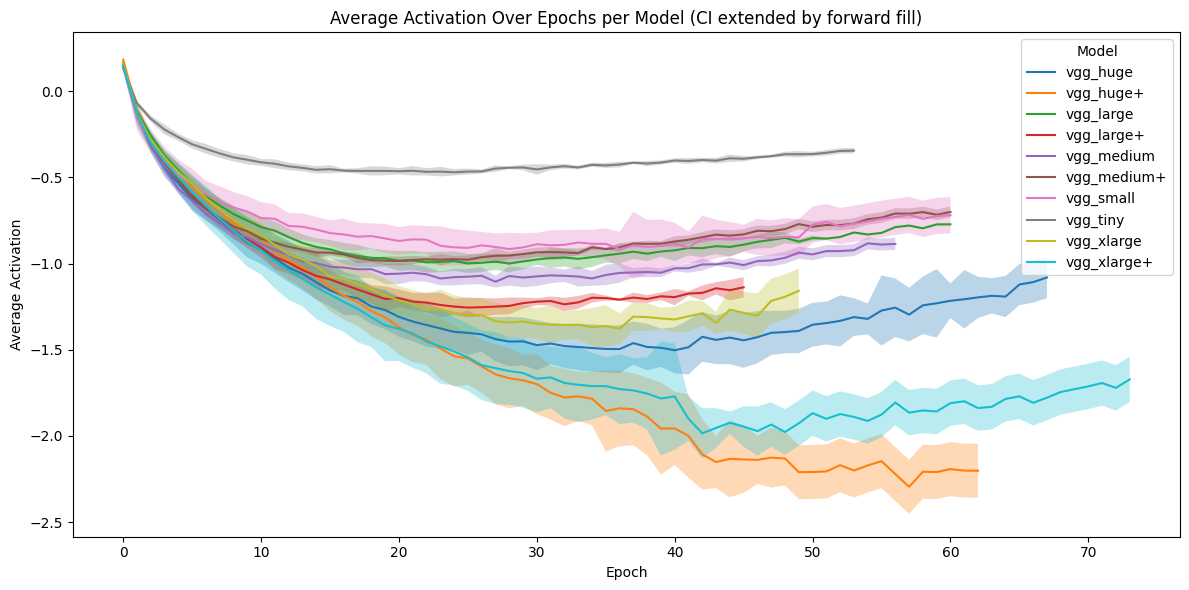

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('fixed_activations.csv')

# Identify layer columns
layer_cols = [col for col in df.columns if col.startswith('Layer')]

# Compute average activation across layers
df['avg_activation'] = df[layer_cols].mean(axis=1)

def compute_ci(df_group):
    runs = df_group['avg_activation'].dropna()
    n = len(runs)
    mean = runs.mean()
    if n > 1:
        sem = runs.sem()
        ci = 1.96 * sem
    else:
        ci = np.nan  # Not enough data for CI
    return pd.Series({'mean': mean, 'ci': ci, 'n': n})

summary = df.groupby(['model_name', 'epoch']).apply(compute_ci).reset_index()

# For each model, forward fill the CI for epochs with missing or nan CI
summary = summary.sort_values(['model_name', 'epoch'])

def fill_ci(df_model):
    df_model['ci_filled'] = df_model['ci'].fillna(method='ffill')  # forward fill
    df_model['ci_filled'] = df_model['ci_filled'].fillna(0)       # fill leading NaNs with 0
    return df_model

summary = summary.groupby('model_name').apply(fill_ci)

# Calculate upper and lower bounds of CI
summary['ci_lower'] = summary['mean'] - summary['ci_filled']
summary['ci_upper'] = summary['mean'] + summary['ci_filled']

# Plot
plt.figure(figsize=(12, 6))

for model in summary['model_name'].unique():
    df_model = summary[summary['model_name'] == model]
    plt.plot(df_model['epoch'], df_model['mean'], label=model)
    plt.fill_between(df_model['epoch'], df_model['ci_lower'], df_model['ci_upper'], alpha=0.3)

plt.title('Average Activation Over Epochs per VGG Model')
plt.xlabel('Epoch')
plt.ylabel('Average Activation')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [ ]:
# Create a 'time' column based on the order (index) of the rows
df['time'] = df.index // 2  # Assuming 3 runs per time point

# Calculate the mean and standard deviation for each time point
time_means = df.groupby('time')['average'].mean()
time_stds = df.groupby('time')['average'].std()

# Convert the mean and std into DataFrame for plotting
time_means_df = pd.DataFrame({'time': time_means.index, 'mean': time_means.values})
time_stds_df = pd.DataFrame({'time': time_stds.index, 'std': time_stds.values})

print(time_means_df)
print(time_stds_df)

# print(time_means_df.iloc[155:165])

# Plot the time series with error bands
plt.figure(figsize=(10, 6))

# Plot the mean values
sns.lineplot(x='time', y='mean', data=time_means_df, label='Mean', color='b')

# Add error bands
plt.fill_between(time_stds_df['time'], 
				 time_means_df['mean'] - time_stds_df['std'], 
				 time_means_df['mean'] + time_stds_df['std'], 
				 color='blue', alpha=0.3)

plt.title("Time Series with Error Bands (Standard Deviation)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()